# Support vector machines and surrogates

In this lessow, we will learn 

- How Support vector machine (SVM) classifiers work and how to use them on different kinds of data
- How to train a SVM to decode the presence or absence of a stimulus from neural activity
- How to assess the performance of a classifier using shuffling methods to create surrogate data

### Introduction

In this lecture, we will look at SVMs, a widely used group of classification algorithms. We'll look at how they can be used to identify stimulus from patterns of neural activity.
_____

### Support vector machines (SVMs)

The SVM is a machine learning algorithm that learns to predict to which of different classes each data point belongs to. To get some intuition about the algorithm, we will start with the case of a **linear SVM** with two classes

### **Linear SVM**

Let our data consist of $N$ pairs $(x_i, y_i)$ with our set of features $x_i$ and labels $y_i$. First, let's consider the case of **linearly separable data**, i.e., data in which classes can be separeted by a straight line.

In that case, we candraw a hyperplane (the **decision boudary**) that perfectly separates the twp classes in many different ways. We look for the linear decision boundary

$$x^Tw +b =0$$

such that the **margin $M$** between the two classes is maximal. To do so, we want to find the largest $M$ such that, for every data point in our set, the **signed/orthogonal distance** from the boundary - $y_i(x_i^Tw + b)$ - is larger than $M$. This amounts to solving the following maximization problem:

$$\max_{w,b,||w||=1}M$$

with constraints:

$$y_i(x_i^Tw + b) \geq M, \ \ \forall_i$$

<img src='svm_linear.webp' width='500'>

### **Non-separable data**

If the data are not linearly separable, the margin problem doesn't have a solution.

However, we can soften our margin constraint by introducing a new set of $N$ variables $\xi_i$, often called **slacks**, to quantify by how much our margin constraint is violated. We can require 

$$y_i(x_i^Tw + b) \geq M(1-\xi_i), \ \ \forall_i$$

with 

$$\xi_i \geq 0, \ \ \sum_{\xi_i} \leq K$$

$K$ quantifies the total amount of slack that we want to allow: a larger $K$ allows for more margin violation and vice versa. We may think of $\xi_i$ as the **relative amount of margin violation** for point $i$. *Note that $\xi_i > 1$ cooresponds to a misclassification of the corresponding data point.*

If we drop the norm constraint on $w$ and define $M = 1/||w||$, we obtain the following minimisation problem:

$$\min ||w||$$

with constraints 

$$y_i(z_i^Tw + b) \geq (1-\xi_i)$$

$$\xi_i \geq 0 \ \ \forall_i \ \ \ \ \ \ \sum_{\xi_i} \leq KK$$

In this lesson, we will use the `sklearn` implementation of SVMs.
_____

### Example: SVMs on synthetic data

In [45]:
from sklearn import svm
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
import pickle
from utils import download_data

# Download data
download_data('https://surfdrive.surf.nl/files/index.php/s/tEenLK693lU9v01')

In [46]:
# Linearly separable data
x_sep, y_sep = make_blobs(1000, 2, centers=[[-1,0],[1,0]], cluster_std = .3)

# Non-linaerly separable data
x_nsep, y_nsep = make_blobs(1000, 2, centers=[[-1,0],[1,0]], cluster_std = .8)

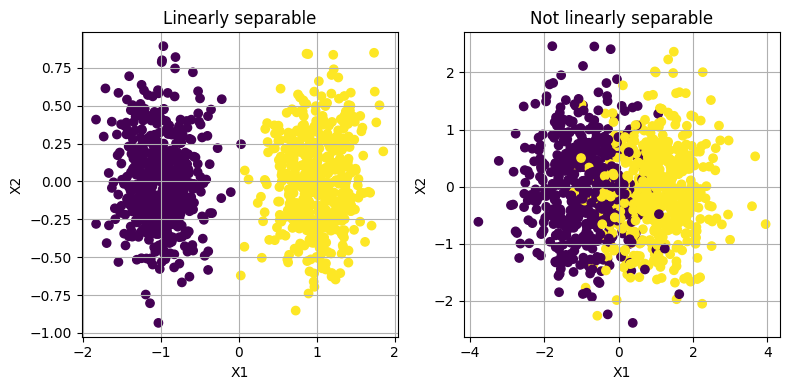

In [47]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.title('Linearly separable')
plt.xlabel('X1')
plt.ylabel('X2')
plt.scatter(x_sep[:,0], x_sep[:,1], c = y_sep)
plt.grid()

plt.subplot(1,2,2)
plt.title('Not linearly separable')
plt.xlabel('X1')
plt.ylabel('X2')
plt.scatter(x_nsep[:,0], x_nsep[:,1], c = y_nsep)
plt.grid()

plt.tight_layout()

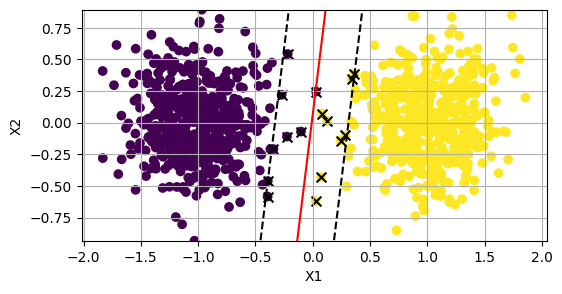

In [48]:
# Use SVM from scikit learn
# Create model object
svc_model = svm.SVC(kernel='linear')

# Fit the model
svc_model.fit(x_sep, y_sep)

plt.figure(figsize=(6,3))
plt.scatter(x_sep[:, 0], x_sep[:,1], c= y_sep)

# Constructing a hyperplane
w = svc_model.coef_[0]
b = svc_model.intercept_[0]

x_points = np.linspace(-1,1)
y_points = -(w[0]/w[1]) * x_points - b/ w[1]

plt.plot(x_points, y_points, 'r')

# Support vectors
plt.scatter(svc_model.support_vectors_[:,0],
            svc_model.support_vectors_[:,1],
            s = 50, c = 'k', marker='x')

# Unit vector
w_hat = w / np.sqrt(np.sum(w**2))

# Margin
margin = 1 / np.sqrt(np.sum(w**2))

# Point from the margin limits
decision_boundary = np.array(list(zip(x_points, y_points)))
points_of_line_above = decision_boundary + w_hat * margin
points_of_line_below = decision_boundary - w_hat * margin

# Plot margin lines
plt.plot(points_of_line_above[:,0], points_of_line_above[:,1], 'k--')
plt.plot(points_of_line_below[:,0], points_of_line_below[:,1], 'k--')

plt.ylim([min(x_sep[:,1]),max(x_sep[:,1])])
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid()

An important feature of SVMs with an **hard margin** (i.e., slack $K = 0$) is that they are only sensible to data points $x_i$ that **lie on the margin** (the crossed blobs above). These points are called the **support vectors**!
_____

### Example: Decoding the stimulus identity from neural activity

Let's now look at how we can use SVM to decode neural activity.

We'll use a dataset built to simulate the following scenario: a mouse is presented with a series of 100 sound stimuli: 50 of type A and the other 50 of type B, randomly intermixed. Each sound is presented during 2 seconds with a 3 second interval. Whilst the animal is exposed to this seris of sounds, we record the activity of $N$ neurons.

We are posed with the question: *Is it possible to tell, by inspection of the neural activity only, which sound the animal was perceiving at each time?*

To answer this question, we'll divide the 2 seconds of sound presentation in 100 ms long time bons and train a linear SVM to decode if either sound A or B was presented.

In [49]:
# Import data
with open('data/simulated_data1.pickle', 'rb') as handle:
    data = pickle.load(handle)

spike_times   = data['spike_times'] # Spike times of each of the 20 cells
stim_onsets   = data['stim_onsets']
stim_type     = data['stim_type']   # Number of trials
stim_duration = data['stim_duration']

In [55]:
stim_type

array([2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1,
       2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2,
       2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2,
       1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2,
       2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2], dtype=int64)

In [ ]:
# Bin the data into 100 ms wide bins
onset, offset = 1, 1
bin_width = 0.1 #seconds
bins = np.arange(-onset, stim_duration + offset + bin_width, bin_width)

n_cells = len(spike_times)
n_trials = len(stim_type)

x = np.zeros((n_cells, n_trials, len(bins) - 1))

for cell in range(n_cells):
    for trial in range(n_trials):

            # Select the spikes from this trial
            sp_indx = np.logical_and(spike_times[cell] > stim_onsets[trial] - onset,
                                     spike_times[cell] < stim_onsets[trial] + offset)
            
            sp_center = spike_times[cell][sp_indx] - stim_onsets[trial]